In [5]:
from typing import List
import math
from datetime import datetime, date
import requests
import numpy as np
import pandas as pd

## Obtencion de datos del clima

### Obtención de URLs

https://www.ncei.noaa.gov/access/services/search/v1/data

```
startDate=yyyy-MM-ddT00:00:00
endDate=yyyy-MM-ddT23:59:59
dataTypes=str
dataset=local-climatological-data
limit=10000
offset=0
```

In [ ]:
data_types = [
  "DailyAverageRelativeHumidity",
  "DailyAverageSeaLevelPressure",
  "DailyAverageWindSpeed",
  "DailyPeakWindDirection",
  "DailyPeakWindSpeed",
  "DailyPrecipitation",
  "DailySustainedWindDirection",
  "DailySustainedWindSpeed",
  "DailyWeather"
]

In [ ]:
def create_request(since: datetime, until: datetime, data_types: List[str], offset: int, limit: int):
  base_url = "https://www.ncei.noaa.gov/access/services/search/v1/data"
  dataset = "local-climatological-data"
  start_date = since.strftime("%Y-%m-%d") + "T00:00:00"
  end_date = until.strftime("%Y-%m-%d") + "T23:59:59"
  params = {
      "startDate": start_date,
      "endDate": end_date,
      "dataTypes": data_types,
      "dataset": dataset,
      "limit": limit,
      "offset": offset

  }
  return requests.get(base_url, params)

In [ ]:
def make_request(since: datetime, until: datetime, data_types: List[str], page: int):
  limit = 500
  offset = page * limit
  res = create_request(since, until, data_types, offset, limit)
  res_data = res.json()
  total_pages = math.ceil(res_data["count"]/limit)
  return total_pages, res_data

In [ ]:
files = []
stations = dict()
page = 0
while True:
  print(f"Fetching page {page}...")
  pages, res = make_request(datetime(1950, 1, 1),date.today(), data_types, page)
  stations.update({
    r['stations'][0]['id']: {
      'name': r['stations'][0]['name'] if 'name' in r['stations'][0].keys() else None,
      'centroid': r['centroid']['point'] if 'centroid' in r.keys() else None
    } for r in res["results"]
  })
  size = res["totalFileSize"]
  files.extend([r["filePath"] for r in res["results"]])
  page += 1
  if page == pages:
    break
files[0:10]

Fetching page 0...
Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...


['/data/local-climatological-data/access/2021/72569024089.csv',
 '/data/local-climatological-data/access/2021/72423093821.csv',
 '/data/local-climatological-data/access/2021/72576024021.csv',
 '/data/local-climatological-data/access/2021/72548094910.csv',
 '/data/local-climatological-data/access/2021/72643014920.csv',
 '/data/local-climatological-data/access/2021/72375003103.csv',
 '/data/local-climatological-data/access/2021/72456013996.csv',
 '/data/local-climatological-data/access/2021/72773024153.csv',
 '/data/local-climatological-data/access/2021/72504094702.csv',
 '/data/local-climatological-data/access/2021/72556014941.csv']

#### Obtener URLs a Tablas por Station

In [ ]:
res.keys()

dict_keys(['dataTypes', 'endDate', 'count', 'bounds', 'totalFileSize', 'stations', 'totalCount', 'results', 'startDate'])

In [ ]:
res["startDate"]

'2006-01-01T00:00:00'

In [ ]:
res["endDate"]

'2022-04-28T23:59:59'

In [ ]:
print(f'{res["totalFileSize"] / 1e9} GB')

63.120440713 GB


In [ ]:
res["totalCount"]

623012

In [ ]:
file_count = len(files)
file_count

7792

In [ ]:
columns = set([r['key'] for r in res["dataTypes"]['buckets'] if r['docCount'] == file_count])

assert_cols = columns.intersection(data_types)
assert len(assert_cols.symmetric_difference(data_types)) == 0
# if assertion fails, modify the while loop to store dataTypes per file
columns

{'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed',
 'DailyWeather',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPresentWeatherType',
 'HourlyPressureChange',
 'HourlyPressureTendency',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyWetBulbTemperature',
 'HourlyWindDirection',
 'HourlyWindGustSpeed',
 'HourlyWindSpeed',
 'MonthlyDaysWithGT001Precip',
 'MonthlyDaysWithGT010Precip',
 'MonthlyDaysWithGT32Temp',
 'MonthlyDaysWithGT90Temp',
 'MonthlyDaysWithLT0Temp',
 'Month

In [ ]:
general_columns = {"STATION", "DATE", "LATITUDE", "LONGITUDE", "ELEVATION", "NAME"}
columns = columns.union(general_columns)
columns

{'DATE',
 'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed',
 'DailyWeather',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPresentWeatherType',
 'HourlyPressureChange',
 'HourlyPressureTendency',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyWetBulbTemperature',
 'HourlyWindDirection',
 'HourlyWindGustSpeed',
 'HourlyWindSpeed',
 'LATITUDE',
 'LONGITUDE',
 'MonthlyDaysWithGT001Precip',
 'MonthlyDaysWithGT010Precip',
 'MonthlyDaysWithGT32Temp',
 'MonthlyDay

In [ ]:
file_path = "urls.txt"
with open(file_path, "w") as file:
  for path in files:
    file.write(f"https://www.ncei.noaa.gov{path}\n")
!head $file_path -n 5

https://www.ncei.noaa.gov/data/local-climatological-data/access/2021/72569024089.csv
https://www.ncei.noaa.gov/data/local-climatological-data/access/2021/72423093821.csv
https://www.ncei.noaa.gov/data/local-climatological-data/access/2021/72576024021.csv
https://www.ncei.noaa.gov/data/local-climatological-data/access/2021/72548094910.csv
https://www.ncei.noaa.gov/data/local-climatological-data/access/2021/72643014920.csv


In [ ]:
prefix='https://www.ncei.noaa.gov/data/local-climatological-data/access/'
string='https://www.ncei.noaa.gov/data/local-climatological-data/access/2021/72569024089.csv'
!name=$(echo "$string" | grep -oP "^$prefix\K.*")
!echo $name

72569024089.csv



In [ ]:
!wc $file_path -l

7792 urls.txt


##### Descargar archivos

descargar_lcd.sh:
```sh
#!/bin/bash
prefix='https://www.ncei.noaa.gov/data/local-climatological-data/access/'
gsutil ls  gs://datasources-storage/ncei_lcd > descargados.txt
mkdir temp_dir
cd temp_dir
cat ../urls.txt | while read line 
do
  name=$(echo "$line" | grep -oP "^$prefix\K.*")
  name=$(echo "${name/\//"_"}")
  cat ../descargados.txt | grep $name
  if [[ $? -eq 0 ]]; then
    continue
  fi
  wget $line -O $name
  if [[ $? -ne 0 ]]; then
    echo "Error[$?] al descargar $line" >> "../descargas.log"
  else
    sed -i '1s/DATE/fecha/g' $name.csv
    gsutil cp $name  gs://datasources-storage/ncei_lcd/
    error=$?
    if [[ $error -ne 0 ]]; then
        echo "Error[$error] al copiar $line" >> "../descargas.log"
    fi
    rm $name
  fi
done
cd ..
rmdir temp_dir
```

```sh
bash descargar_lcd.sh && shutdown now &

```

#### Guardar Stations

In [ ]:
len(stations.keys())

538

In [ ]:
stations[list(stations.keys())[0]]

{'centroid': [-106.47371, 42.89779],
 'name': 'CASPER NATRONA CO AIRPORT, WY US'}

In [ ]:
df_stations = pd.DataFrame.from_dict(stations, orient="index")
df_stations

,name,centroid
72569024089,"CASPER NATRONA CO AIRPORT, WY US","[-106.47371, 42.89779]"
72423093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US","[-85.7391, 38.1811]"
72576024021,"LANDER AIRPORT, WY US","[-108.72611, 42.81538]"
72548094910,"WATERLOO MUNICIPAL AIRPORT, IA US","[-92.4011, 42.5544]"
72643014920,"LA CROSSE MUNICIPAL AIRPORT, WI US","[-91.2527, 43.8788]"
...,...,...
91366040604,"KWAJALEIN, MH RM","[167.73333, 8.73333]"
91376040710,None,None
72691724284,"NORTH BEND SOUTHWEST OREGON REGIONAL AIRPORT, ...","[-124.24361, 43.41333]"
72571703016,"RIFLE GARFIELD CO AIRPORT, CO US","[-107.71972, 39.52778]"


In [ ]:
df_stations.dtypes

name        object
centroid    object
dtype: object

In [ ]:
df_stations.iloc[0]

name        CASPER NATRONA CO AIRPORT, WY US
centroid              [-106.47371, 42.89779]
Name: 72569024089, dtype: object

In [ ]:
df_stations.dropna(subset=['centroid'], inplace=True)

In [ ]:
df_stations[['longitude','latitude']] = pd.DataFrame(df_stations.centroid.tolist(), index= df_stations.index)


In [ ]:
df_stations

,name,centroid,longitude,latitude
72569024089,"CASPER NATRONA CO AIRPORT, WY US","[-106.47371, 42.89779]",-106.47371,42.89779
72423093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US","[-85.7391, 38.1811]",-85.73910,38.18110
72576024021,"LANDER AIRPORT, WY US","[-108.72611, 42.81538]",-108.72611,42.81538
72548094910,"WATERLOO MUNICIPAL AIRPORT, IA US","[-92.4011, 42.5544]",-92.40110,42.55440
72643014920,"LA CROSSE MUNICIPAL AIRPORT, WI US","[-91.2527, 43.8788]",-91.25270,43.87880
...,...,...,...,...
99999940504,"POHNPEI WEATHER SERVICE OFFICE, FM FM","[158.2167, 6.9667]",158.21670,6.96670
91366040604,"KWAJALEIN, MH RM","[167.73333, 8.73333]",167.73333,8.73333
72691724284,"NORTH BEND SOUTHWEST OREGON REGIONAL AIRPORT, ...","[-124.24361, 43.41333]",-124.24361,43.41333
72571703016,"RIFLE GARFIELD CO AIRPORT, CO US","[-107.71972, 39.52778]",-107.71972,39.52778


In [ ]:
df_stations.to_csv('stations.csv')

#### Clustering para Stations

Usando K-means

In [ ]:
df_stations = pd.read_csv('stations.csv', index_col=0)
df_stations.head()

,name,centroid,longitude,latitude
72569024089,"CASPER NATRONA CO AIRPORT, WY US","[-106.47371, 42.89779]",-106.47371,42.89779
72423093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US","[-85.7391, 38.1811]",-85.73910,38.18110
72576024021,"LANDER AIRPORT, WY US","[-108.72611, 42.81538]",-108.72611,42.81538
72548094910,"WATERLOO MUNICIPAL AIRPORT, IA US","[-92.4011, 42.5544]",-92.40110,42.55440
72643014920,"LA CROSSE MUNICIPAL AIRPORT, WI US","[-91.2527, 43.8788]",-91.25270,43.87880


In [ ]:
from sklearn import preprocessing, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.cluster.vq import vq
import folium
import geopy

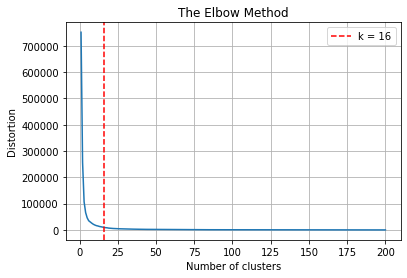

In [ ]:
X = df_stations[["latitude","longitude"]]
max_k = 200
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
k = 16

In [ ]:

model = cluster.KMeans(n_clusters=k, init='k-means++')
X = df_stations[["latitude","longitude"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
df_stations[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df_stations.head()

,name,centroid,longitude,latitude,cluster,centroids
72569024089,"CASPER NATRONA CO AIRPORT, WY US","[-106.47371, 42.89779]",-106.47371,42.89779,13,0
72423093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US","[-85.7391, 38.1811]",-85.73910,38.18110,9,0
72576024021,"LANDER AIRPORT, WY US","[-108.72611, 42.81538]",-108.72611,42.81538,13,0
72548094910,"WATERLOO MUNICIPAL AIRPORT, IA US","[-92.4011, 42.5544]",-92.40110,42.55440,15,0
72643014920,"LA CROSSE MUNICIPAL AIRPORT, WI US","[-91.2527, 43.8788]",-91.25270,43.87880,15,0


In [ ]:
df_stations = df_stations[['name','longitude', 'latitude', 'cluster', 'centroids']]
df_stations

,name,longitude,latitude,cluster,centroids
72569024089,"CASPER NATRONA CO AIRPORT, WY US",-106.47371,42.89779,13,0
72423093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",-85.73910,38.18110,9,0
72576024021,"LANDER AIRPORT, WY US",-108.72611,42.81538,13,0
72548094910,"WATERLOO MUNICIPAL AIRPORT, IA US",-92.40110,42.55440,15,0
72643014920,"LA CROSSE MUNICIPAL AIRPORT, WI US",-91.25270,43.87880,15,0
...,...,...,...,...,...
99999940504,"POHNPEI WEATHER SERVICE OFFICE, FM FM",158.21670,6.96670,1,0
91366040604,"KWAJALEIN, MH RM",167.73333,8.73333,1,0
72691724284,"NORTH BEND SOUTHWEST OREGON REGIONAL AIRPORT, ...",-124.24361,43.41333,2,0
72571703016,"RIFLE GARFIELD CO AIRPORT, CO US",-107.71972,39.52778,5,0


In [ ]:
df_stations["name"] = df_stations["name"].apply(lambda x: x.replace(",", ""))

In [ ]:
df_stations

,name,longitude,latitude,cluster,centroids
72569024089,CASPER NATRONA CO AIRPORT WY US,-106.47371,42.89779,13,0
72423093821,LOUISVILLE INTERNATIONAL AIRPORT KY US,-85.73910,38.18110,9,0
72576024021,LANDER AIRPORT WY US,-108.72611,42.81538,13,0
72548094910,WATERLOO MUNICIPAL AIRPORT IA US,-92.40110,42.55440,15,0
72643014920,LA CROSSE MUNICIPAL AIRPORT WI US,-91.25270,43.87880,15,0
...,...,...,...,...,...
99999940504,POHNPEI WEATHER SERVICE OFFICE FM FM,158.21670,6.96670,1,0
91366040604,KWAJALEIN MH RM,167.73333,8.73333,1,0
72691724284,NORTH BEND SOUTHWEST OREGON REGIONAL AIRPORT O...,-124.24361,43.41333,2,0
72571703016,RIFLE GARFIELD CO AIRPORT CO US,-107.71972,39.52778,5,0


In [ ]:
df_stations.to_csv('stations_clustered_16.csv')

#### Visualization for clustered Stations

In [ ]:
df_stations = pd.read_csv('stations_clustered_16.csv', index_col=0)
df_stations = df_stations[['name','longitude', 'latitude', 'cluster', 'centroids']]
df_stations

,name,longitude,latitude,cluster,centroids
72569024089,CASPER NATRONA CO AIRPORT WY US,-106.47371,42.89779,13,0
72423093821,LOUISVILLE INTERNATIONAL AIRPORT KY US,-85.73910,38.18110,9,0
72576024021,LANDER AIRPORT WY US,-108.72611,42.81538,13,0
72548094910,WATERLOO MUNICIPAL AIRPORT IA US,-92.40110,42.55440,15,0
72643014920,LA CROSSE MUNICIPAL AIRPORT WI US,-91.25270,43.87880,15,0
...,...,...,...,...,...
99999940504,POHNPEI WEATHER SERVICE OFFICE FM FM,158.21670,6.96670,1,0
91366040604,KWAJALEIN MH RM,167.73333,8.73333,1,0
72691724284,NORTH BEND SOUTHWEST OREGON REGIONAL AIRPORT O...,-124.24361,43.41333,2,0
72571703016,RIFLE GARFIELD CO AIRPORT CO US,-107.71972,39.52778,5,0


Text(0.5, 1.0, 'Clustering (k=16)')

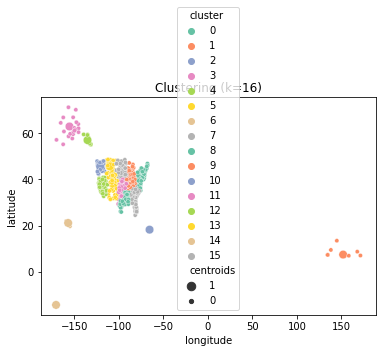

In [ ]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="longitude", y="latitude", data=df_stations, 
                palette=sns.color_palette("Set2",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
#th_centroids = model.cluster_centers_

In [ ]:
colors = np.array(*[sns.color_palette("Set2",k)])*255
colors = ["#"+"".join([f'{hex(int(i))[2:]}0'[:2] for i in c]) for c in colors]
colors

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3']

In [ ]:
city = "US"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

United States
[lat, long]: [39.7837304, -100.445882]


In [ ]:
x, y = "latitude", "longitude"
color = "cluster"
size = "Staff"
popup = "name"
marker = "centroids"
data = df_stations.copy()
## create color column
lst_elements = sorted(list(df_stations[color].unique()))

data["color"] = data[color].apply(lambda x: 
                colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = 1
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(df_stations[marker].unique()))
## plot the map
map_

### Obtencion de datos de huracanes (HURDAT)


https://www.nhc.noaa.gov/data/hurdat/hurdat2-format-nov2019.pdf



In [6]:
!wget "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2021-041922.txt" -O hurdat2.txt

--2022-05-09 17:41:43--  https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2021-041922.txt
Resolving www.nhc.noaa.gov (www.nhc.noaa.gov)... 13.224.10.24, 13.224.10.41, 13.224.10.17, ...
Connecting to www.nhc.noaa.gov (www.nhc.noaa.gov)|13.224.10.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6814698 (6.5M) [text/plain]
Saving to: ‘hurdat2.txt’

hurdat2.txt         100%[===================>]   6.50M  26.4MB/s    in 0.2s    

2022-05-09 17:41:43 (26.4 MB/s) - ‘hurdat2.txt’ saved [6814698/6814698]



In [7]:
!head hurdat2.txt

AL011851,            UNNAMED,     14,
18510625, 0000,  , HU, 28.0N,  94.8W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999
18510625, 0600,  , HU, 28.0N,  95.4W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999
18510625, 1200,  , HU, 28.0N,  96.0W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999
18510625, 1800,  , HU, 28.1N,  96.5W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999
18510625, 2100, L, HU, 28.2N,  96.8W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999
18510626, 0000,  , HU, 28.2N,  97.0W,  70, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999
18510626, 0600,  , TS, 28.3N,  97.6W,  60, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999
18510626, 1200,  , TS, 28.4N,  98.3W,  60, -999, -999, -999, -999, -999, -999, -

In [8]:
lines = []
with open("hurdat2.txt") as file:
  lines = file.readlines()
lines[0:10]

['AL011851,            UNNAMED,     14,\n',
 '18510625, 0000,  , HU, 28.0N,  94.8W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n',
 '18510625, 0600,  , HU, 28.0N,  95.4W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n',
 '18510625, 1200,  , HU, 28.0N,  96.0W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n',
 '18510625, 1800,  , HU, 28.1N,  96.5W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n',
 '18510625, 2100, L, HU, 28.2N,  96.8W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n',
 '18510626, 0000,  , HU, 28.2N,  97.0W,  70, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n',
 '18510626, 0600,  , TS, 28.3N,  97.6W,  60, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n',
 '18510626, 1200,  , TS, 28.4N, 

In [9]:
hurricanes = []
for line in lines:
  cols = [col.strip() for col in line.split(',')]
  if len(cols) <= 4:
    year=int(cols[0][-4:])
    hurricanes.append({"name": cols[1], "data": [], "year":  year})
  else:
    data = {
        "date": datetime(int(cols[0][0:4]), int(cols[0][4:6]), int(cols[0][6:8]), int(cols[1][0:2]), int(cols[1][2:4])),
        "record_identifier": cols[2],
        "status_of_system": cols[3],
        "latitude": cols[4],
        "longitude": cols[5],
        "maximum_sustained wind": cols[6],
        "maximum_pressure": cols[7]

    }
    hurricanes[-1]["data"].append(data)
  

In [10]:
hurricanes[-1]["year"]

2021

In [11]:
usables = [h for h in hurricanes if h['year'] >= 2006 ]

In [12]:
len(usables)

273

In [13]:
hurricanes_df = []
for idx, hurricane in enumerate(usables):
  for r in hurricane["data"]:
    lat = r["latitude"]
    lon = r["longitude"]
    lat = float(lat[:-1]) *(1 if lat[-1] == 'N' else -1)
    lon = float(lon[:-1]) *(1 if lon[-1] == 'E' else -1)
    hurricanes_df.append({
      "id": idx,
      "name": hurricane["name"],
      "year": hurricane["year"],
      **r,
      "latitude": lat,
      "longitude": lon
    })

hurricanes_df[-1]

{'date': datetime.datetime(2021, 11, 8, 0, 0),
 'id': 272,
 'latitude': 43.2,
 'longitude': -29.7,
 'maximum_pressure': '1006',
 'maximum_sustained wind': '40',
 'name': 'WANDA',
 'record_identifier': '',
 'status_of_system': 'LO',
 'year': 2021}

In [14]:
{h['date'].year for h in hurricanes_df }

{2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021}

In [15]:
hurricanes_df = pd.DataFrame(hurricanes_df)
hurricanes_df.tail()

,id,name,year,date,record_identifier,status_of_system,latitude,longitude,maximum_sustained wind,maximum_pressure
8231,272,WANDA,2021,2021-11-07 00:00:00,,TS,37.4,-37.4,35,1003
8232,272,WANDA,2021,2021-11-07 06:00:00,,TS,38.1,-36.4,35,1004
8233,272,WANDA,2021,2021-11-07 12:00:00,,LO,39.2,-34.9,35,1006
8234,272,WANDA,2021,2021-11-07 18:00:00,,LO,40.9,-32.8,40,1006
8235,272,WANDA,2021,2021-11-08 00:00:00,,LO,43.2,-29.7,40,1006


In [16]:
hurricanes_df.replace({"-999": None}, inplace=True)

In [17]:
hurricanes_df.to_csv("hurricanes.csv")

In [18]:
hurricanes_df = pd.read_csv("hurricanes.csv", index_col=[0])
hurricanes_df.dropna(subset=['maximum_sustained wind'], inplace=True)
hurricanes_df

,id,name,year,date,record_identifier,status_of_system,latitude,longitude,maximum_sustained wind,maximum_pressure
0,0,ALBERTO,2006,2006-06-10 06:00:00,NaN,TD,20.0,-85.0,25,1004
1,0,ALBERTO,2006,2006-06-10 12:00:00,NaN,TD,21.0,-85.3,30,1003
2,0,ALBERTO,2006,2006-06-10 18:00:00,NaN,TD,21.9,-85.7,30,1003
3,0,ALBERTO,2006,2006-06-11 00:00:00,NaN,TS,22.5,-86.3,35,1003
4,0,ALBERTO,2006,2006-06-11 06:00:00,NaN,TS,23.1,-87.1,35,1003
...,...,...,...,...,...,...,...,...,...,...
8231,272,WANDA,2021,2021-11-07 00:00:00,NaN,TS,37.4,-37.4,35,1003
8232,272,WANDA,2021,2021-11-07 06:00:00,NaN,TS,38.1,-36.4,35,1004
8233,272,WANDA,2021,2021-11-07 12:00:00,NaN,LO,39.2,-34.9,35,1006
8234,272,WANDA,2021,2021-11-07 18:00:00,NaN,LO,40.9,-32.8,40,1006


In [19]:
status_of_system_info = """
TD – Tropical cyclone of tropical depression intensity (< 34 knots)
TS – Tropical cyclone of tropical storm intensity (34-63 knots)
HU – Tropical cyclone of hurricane intensity (> 64 knots)
EX – Extratropical cyclone (of any intensity)
SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
WV – Tropical Wave (of any intensity)
DB – Disturbance (of any intensity) 
"""
status_of_system_raw = status_of_system_info.splitlines()
status_of_system_names = dict()
for s in status_of_system_raw:
  st = s.split(" – ", 2)
  if len(st) == 2:
    status_of_system_names.update({st[0]: st[1]})
status_of_system_names

{'DB': 'Disturbance (of any intensity) ',
 'EX': 'Extratropical cyclone (of any intensity)',
 'HU': 'Tropical cyclone of hurricane intensity (> 64 knots)',
 'LO': 'A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)',
 'SD': 'Subtropical cyclone of subtropical depression intensity (< 34 knots)',
 'SS': 'Subtropical cyclone of subtropical storm intensity (> 34 knots)',
 'TD': 'Tropical cyclone of tropical depression intensity (< 34 knots)',
 'TS': 'Tropical cyclone of tropical storm intensity (34-63 knots)',
 'WV': 'Tropical Wave (of any intensity)'}

In [20]:
status_of_system_df = hurricanes_df.groupby(['status_of_system'])['maximum_sustained wind'].describe().sort_values(by=['mean']).reset_index()
status_of_system_df["name"] = status_of_system_df.apply(lambda x: status_of_system_names[x['status_of_system']], axis=1)
status_of_system_df

,status_of_system,count,mean,std,min,25%,50%,75%,max,name
0,LO,1182.0,26.480541,6.477934,15.0,25.0,25.0,30.0,80.0,"A low that is neither a tropical cyclone, a su..."
1,TD,1005.0,28.671642,2.631339,15.0,30.0,30.0,30.0,30.0,Tropical cyclone of tropical depression intens...
2,WV,45.0,29.333333,3.630677,25.0,25.0,30.0,30.0,40.0,Tropical Wave (of any intensity)
3,DB,137.0,29.854015,6.500611,20.0,25.0,30.0,35.0,50.0,Disturbance (of any intensity)
4,SD,29.0,30.000000,0.000000,30.0,30.0,30.0,30.0,30.0,Subtropical cyclone of subtropical depression ...
5,SS,167.0,41.736527,5.985126,35.0,35.0,40.0,45.0,60.0,Subtropical cyclone of subtropical storm inten...
6,EX,1039.0,43.464870,12.875440,15.0,35.0,40.0,50.0,75.0,Extratropical cyclone (of any intensity)
7,TS,2954.0,45.485782,8.174525,35.0,40.0,45.0,50.0,60.0,Tropical cyclone of tropical storm intensity (...
8,HU,1678.0,87.538737,21.208072,65.0,70.0,80.0,100.0,160.0,Tropical cyclone of hurricane intensity (> 64 ...


In [21]:
hurricanes_df['day'] = pd.to_datetime(hurricanes_df['date']).dt.date
hurricanes_df

,id,name,year,date,record_identifier,status_of_system,latitude,longitude,maximum_sustained wind,maximum_pressure,day
0,0,ALBERTO,2006,2006-06-10 06:00:00,NaN,TD,20.0,-85.0,25,1004,2006-06-10
1,0,ALBERTO,2006,2006-06-10 12:00:00,NaN,TD,21.0,-85.3,30,1003,2006-06-10
2,0,ALBERTO,2006,2006-06-10 18:00:00,NaN,TD,21.9,-85.7,30,1003,2006-06-10
3,0,ALBERTO,2006,2006-06-11 00:00:00,NaN,TS,22.5,-86.3,35,1003,2006-06-11
4,0,ALBERTO,2006,2006-06-11 06:00:00,NaN,TS,23.1,-87.1,35,1003,2006-06-11
...,...,...,...,...,...,...,...,...,...,...,...
8231,272,WANDA,2021,2021-11-07 00:00:00,NaN,TS,37.4,-37.4,35,1003,2021-11-07
8232,272,WANDA,2021,2021-11-07 06:00:00,NaN,TS,38.1,-36.4,35,1004,2021-11-07
8233,272,WANDA,2021,2021-11-07 12:00:00,NaN,LO,39.2,-34.9,35,1006,2021-11-07
8234,272,WANDA,2021,2021-11-07 18:00:00,NaN,LO,40.9,-32.8,40,1006,2021-11-07


In [22]:
hurricanes_daily = hurricanes_df.groupby(['id', 'day']).max()
hurricanes_daily

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  """Entry point for launching an IPython kernel.


name  year                 date status_of_system  latitude  \
id  day                                                                         
0   2006-06-10  ALBERTO  2006  2006-06-10 18:00:00               TD      21.9   
    2006-06-11  ALBERTO  2006  2006-06-11 18:00:00               TS      24.3   
    2006-06-12  ALBERTO  2006  2006-06-12 18:00:00               TS      27.5   
    2006-06-13  ALBERTO  2006  2006-06-13 18:00:00               TS      30.3   
    2006-06-14  ALBERTO  2006  2006-06-14 18:00:00               TS      35.5   
...                 ...   ...                  ...              ...       ...   
272 2021-11-04    WANDA  2021  2021-11-04 18:00:00               TS      42.1   
    2021-11-05    WANDA  2021  2021-11-05 18:00:00               TS      42.3   
    2021-11-06    WANDA  2021  2021-11-06 18:00:00               TS      38.4   
    2021-11-07    WANDA  2021  2021-11-07 18:00:00               TS      40.9   
    2021-11-08    WANDA  2021  2021-11-08 00:00:00               LO      43.2   

                longitude  maximum_sustained wind  maximum_pressure  
id  day                                                              
0   2006-06-10      -85.0                      30              1004  
    2006-06-11      -86.3                      40              1004  
    2006-06-12      -85.4                      60              1004  
    2006-06-13      -83.5                      60               998  
    2006-06-14      -77.5                      35              1003  
...                   ...                     ...               ...  
272 2021-11-04      -39.6                      45               994  
    2021-11-05      -37.5                      45               996  
    2021-11-06      -38.0                      45              1002  
    2021-11-07      -32.8                      40              1006  
    2021-11-08      -29.7                      40              1006  

[2207 rows x 8 columns]

In [23]:
hurricanes_daily.to_csv('hurricanes_daily.csv')

In [24]:
hurricanes_daily.describe()

,year,latitude,longitude,maximum_sustained wind,maximum_pressure
count,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000
mean,2014.188944,27.926552,-58.268691,50.702311,997.864069
std,4.675907,11.247869,22.194526,25.455607,15.775729
min,2006.000000,7.500000,-106.300000,15.000000,916.000000
25%,2010.000000,18.500000,-76.700000,30.000000,993.000000
50%,2015.000000,27.300000,-59.200000,45.000000,1004.000000
75%,2018.000000,35.300000,-41.000000,60.000000,1008.000000
max,2021.000000,69.000000,5.300000,160.000000,1021.000000


In [30]:
print(f"Número de días con huracanes: {len(hurricanes_daily.reset_index().groupby(['day']).max())}")

Número de días con huracanes: 1503


## Setup Hive

In [ ]:
df_cols = pd.read_csv('lcd_columns.csv')
s_cols = df_cols.iloc[0]

In [ ]:
cols = []
for name, hive_type in s_cols.iteritems():
    cols.append(f"  {name} STRING")
cols = ",\n".join(cols)
print(
f"""
DROP TABLE IF EXISTS lcd;
CREATE EXTERNAL TABLE lcd
(
{cols}
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
   "separatorChar" = ",",
   "quoteChar"     = "\\""
) 
STORED AS TEXTFILE
location '/user/lcd/ncei_lcd'
TBLPROPERTIES ("skip.header.line.count"="1");
SELECT * FROM lcd LIMIT 2;
"""
)


DROP TABLE IF EXISTS lcd;
CREATE EXTERNAL TABLE lcd
(
  STATION STRING,
  fecha STRING,
  LATITUDE STRING,
  LONGITUDE STRING,
  ELEVATION STRING,
  NAME STRING,
  REPORT_TYPE STRING,
  SOURCE STRING,
  HourlyAltimeterSetting STRING,
  HourlyDewPointTemperature STRING,
  HourlyDryBulbTemperature STRING,
  HourlyPrecipitation STRING,
  HourlyPresentWeatherType STRING,
  HourlyPressureChange STRING,
  HourlyPressureTendency STRING,
  HourlyRelativeHumidity STRING,
  HourlySkyConditions STRING,
  HourlySeaLevelPressure STRING,
  HourlyStationPressure STRING,
  HourlyVisibility STRING,
  HourlyWetBulbTemperature STRING,
  HourlyWindDirection STRING,
  HourlyWindGustSpeed STRING,
  HourlyWindSpeed STRING,
  Sunrise STRING,
  Sunset STRING,
  DailyAverageDewPointTemperature STRING,
  DailyAverageDryBulbTemperature STRING,
  DailyAverageRelativeHumidity STRING,
  DailyAverageSeaLevelPressure STRING,
  DailyAverageStationPressure STRING,
  DailyAverageWetBulbTemperature STRING,
  DailyAverage

In [ ]:
cols = []
for name, hive_type in s_cols.iteritems():
    if hive_type == "STRING":
      cols.append(f"  TRIM({name}) as {name}")
    elif isinstance(hive_type, str):
      cols.append(f"  CAST({name} as {hive_type}) as {name}")
cols = ",\n".join(cols)
print(
f"""
CREATE TABLE lcd_daily AS 
SELECT * FROM (SELECT
{cols}
FROM lcd) as t1 WHERE REPORT_TYPE = 'SOD';
SELECT * FROM lcd_daily LIMIT 2;
"""
)


CREATE TABLE lcd_daily AS 
SELECT * FROM (SELECT
  CAST(STATION as BIGINT) as STATION,
  CAST(fecha as TIMESTAMP) as fecha,
  CAST(LATITUDE as FLOAT) as LATITUDE,
  CAST(LONGITUDE as FLOAT) as LONGITUDE,
  CAST(ELEVATION as FLOAT) as ELEVATION,
  TRIM(NAME) as NAME,
  TRIM(REPORT_TYPE) as REPORT_TYPE,
  CAST(SOURCE as INT) as SOURCE,
  CAST(Sunrise as FLOAT) as Sunrise,
  CAST(Sunset as FLOAT) as Sunset,
  CAST(DailyAverageDewPointTemperature as FLOAT) as DailyAverageDewPointTemperature,
  CAST(DailyAverageDryBulbTemperature as FLOAT) as DailyAverageDryBulbTemperature,
  CAST(DailyAverageRelativeHumidity as FLOAT) as DailyAverageRelativeHumidity,
  CAST(DailyAverageSeaLevelPressure as FLOAT) as DailyAverageSeaLevelPressure,
  CAST(DailyAverageStationPressure as FLOAT) as DailyAverageStationPressure,
  CAST(DailyAverageWetBulbTemperature as FLOAT) as DailyAverageWetBulbTemperature,
  CAST(DailyAverageWindSpeed as FLOAT) as DailyAverageWindSpeed,
  CAST(DailyMaximumDryBulbTemperature as

In [ ]:
cols = []
for name, hive_type in s_cols.iteritems():
  if isinstance(hive_type, str):
    cols.append(f'{name} {hive_type}')
cols = ",\n".join(cols)
print(
f"""
CREATE TABLE lcd_daily
(
{cols}
);
SELECT * FROM lcd_daily LIMIT 2;
"""
)


CREATE TABLE lcd_daily
(
STATION BIGINT,
fecha TIMESTAMP,
LATITUDE FLOAT,
LONGITUDE FLOAT,
ELEVATION FLOAT,
NAME STRING,
REPORT_TYPE STRING,
SOURCE INT,
Sunrise FLOAT,
Sunset FLOAT,
DailyAverageDewPointTemperature FLOAT,
DailyAverageDryBulbTemperature FLOAT,
DailyAverageRelativeHumidity FLOAT,
DailyAverageSeaLevelPressure FLOAT,
DailyAverageStationPressure FLOAT,
DailyAverageWetBulbTemperature FLOAT,
DailyAverageWindSpeed FLOAT,
DailyMaximumDryBulbTemperature FLOAT,
DailyMinimumDryBulbTemperature FLOAT,
DailyPeakWindDirection FLOAT,
DailyPeakWindSpeed FLOAT,
DailyPrecipitation FLOAT,
DailySustainedWindDirection FLOAT,
DailySustainedWindSpeed FLOAT
);
SELECT * FROM lcd_daily LIMIT 2;



##### Otras tablas

In [ ]:
def create_external_table(cols_def: list, table_name: str, file_path: str, header: int):
  cols = []
  for name, hive_type in cols_def:
    if isinstance(hive_type, str):
      cols.append(f'  {name} {hive_type}')
  cols = ",\n".join(cols)
  print(
  f"""
DROP TABLE IF EXISTS {table_name};
CREATE EXTERNAL TABLE {table_name}
(
{cols}
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\\n'
STORED AS TEXTFILE
location '{file_path}'
{f'TBLPROPERTIES ("skip.header.line.count"="{header}")' if header else ''}
;
SELECT * FROM {table_name} LIMIT 2;
  """
  )

In [ ]:
df_hurricanes = pd.read_csv('hurricanes.csv', index_col=[0])
df_hurricanes.head()

,id,name,year,date,record_identifier,status_of_system,latitude,longitude,maximum_sustained wind,maximum_pressure
0,0,ALBERTO,2006,2006-06-10 06:00:00,NaN,TD,20.0,-85.0,25,1004
1,0,ALBERTO,2006,2006-06-10 12:00:00,NaN,TD,21.0,-85.3,30,1003
2,0,ALBERTO,2006,2006-06-10 18:00:00,NaN,TD,21.9,-85.7,30,1003
3,0,ALBERTO,2006,2006-06-11 00:00:00,NaN,TS,22.5,-86.3,35,1003
4,0,ALBERTO,2006,2006-06-11 06:00:00,NaN,TS,23.1,-87.1,35,1003


In [ ]:
cols_types = [
    ("num", "INT"),
    ("id", "INT"),
    ("name", "STRING"),
    ("anio", "INT"),
    ("fecha", "TIMESTAMP"),
    ("record_identifier", "STRING"),
    ("status_of_system", "STRING"),
    ("latitude", "FLOAT"),
    ("longitude", "FLOAT"),
    ("maximum_sustained_wind", "FLOAT"),
    ("maximum_pressure", "FLOAT"),
]

In [ ]:
create_external_table(cols_types, 'hurricanes', '/user/hurricanes', 1)


DROP TABLE IF EXISTS hurricanes;
CREATE EXTERNAL TABLE hurricanes
(
  num INT,
  id INT,
  name STRING,
  anio INT,
  fecha TIMESTAMP,
  record_identifier STRING,
  status_of_system STRING,
  latitude FLOAT,
  longitude FLOAT,
  maximum_sustained_wind FLOAT,
  maximum_pressure FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n'
STORED AS TEXTFILE
location '/user/hurricanes'
TBLPROPERTIES ("skip.header.line.count"="1")
;
SELECT * FROM hurricanes LIMIT 2;
  


In [ ]:
!head stations_clustered_16.csv

,name,longitude,latitude,cluster,centroids
72569024089,"CASPER NATRONA CO AIRPORT, WY US",-106.47371,42.89779,13,0
72423093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",-85.7391,38.1811,9,0
72576024021,"LANDER AIRPORT, WY US",-108.72611,42.81538,13,0
72548094910,"WATERLOO MUNICIPAL AIRPORT, IA US",-92.4011,42.5544,15,0
72643014920,"LA CROSSE MUNICIPAL AIRPORT, WI US",-91.2527,43.8788,15,0
72375003103,"FLAGSTAFF AIRPORT, AZ US",-111.6663,35.1441,5,0
72456013996,"TOPEKA ASOS, KS US",-95.6261,39.0725,3,0
72773024153,"MISSOULA INTERNATIONAL AIRPORT, MT US",-114.0925,46.9208,13,0
72504094702,"IGOR I SIKORSKY MEMORIAL AIRPORT, CT US",-73.12669,41.16422,0,0


In [ ]:
cols_types_stations = [
    ("id", "BIGINT"),
    ("name", "STRING"),
    ("longitude", "FLOAT"),
    ("latitude", "FLOAT"),
    ("cluster", "INT"),
    ("centroids", "INT"),
]

In [ ]:
create_external_table(cols_types_stations, 'stations', '/user/stations', 1)


DROP TABLE IF EXISTS stations;
CREATE EXTERNAL TABLE stations
(
  id BIGINT,
  name STRING,
  longitude FLOAT,
  latitude FLOAT,
  cluster INT,
  centroids INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n'
STORED AS TEXTFILE
location '/user/stations'
TBLPROPERTIES ("skip.header.line.count"="1")
;
SELECT * FROM stations LIMIT 2;
  
